In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
from sklearn.preprocessing import StandardScaler
plt.rcParams['figure.figsize'] = (9,6)
import mlflow
import mlflow.sklearn
import dagshub
dagshub.init(repo_owner='shashi-hue', repo_name='Mlops-Forward-Customer-Value', mlflow=True)

mlflow.set_experiment("Model experimentation")

Accessing as shashi-hue

Initialized MLflow to track repo "shashi-hue/Mlops-Forward-Customer-Value"

Repository shashi-hue/Mlops-Forward-Customer-Value initialized!

<Experiment: artifact_location='mlflow-artifacts:/ebc8eb4ec149427997f005ae21b919e3', creation_time=1768458705775, experiment_id='1', last_update_time=1768458705775, lifecycle_stage='active', name='Model experimentation', tags={'mlflow.experimentKind': 'custom_model_development'}>

### Load dataset

In [78]:
df = pd.read_csv("retail-data.csv")

In [79]:
df.head()

,Invoice,StockCode,Description,Quantity,InvoiceDate,Price,Customer ID,Country
0,489434,85048,15CM CHRISTMAS GLASS BALL 20 LIGHTS,12,2009-12-01 07:45:00,6.95,13085.0,United Kingdom
1,489434,79323P,PINK CHERRY LIGHTS,12,2009-12-01 07:45:00,6.75,13085.0,United Kingdom
2,489434,79323W,WHITE CHERRY LIGHTS,12,2009-12-01 07:45:00,6.75,13085.0,United Kingdom
3,489434,22041,"RECORD FRAME 7"" SINGLE SIZE",48,2009-12-01 07:45:00,2.10,13085.0,United Kingdom
4,489434,21232,STRAWBERRY CERAMIC TRINKET BOX,24,2009-12-01 07:45:00,1.25,13085.0,United Kingdom




---

### Data Cleaning

In [80]:
df.isnull().sum()

Invoice             0
StockCode           0
Description      4382
Quantity            0
InvoiceDate         0
Price               0
Customer ID    243007
Country             0
dtype: int64

Since we are focusing on the Customer lifetime value Customer ID is needed, so we are gonna remove rows without Customer ID.

In [81]:
df = df.dropna(subset=['Customer ID'])

Invoice starting with letter 'C' shows it is a cancelled order, let's remove such kind of orders.

In [82]:
df = df[~df['Invoice'].str.startswith('C')]

In [83]:
df['Quantity'].min()

np.int64(1)

In [84]:
df['Price'].min()

np.float64(0.0)

In [85]:
df.dtypes

Invoice         object
StockCode       object
Description     object
Quantity         int64
InvoiceDate     object
Price          float64
Customer ID    float64
Country         object
dtype: object

In [86]:
df['InvoiceDate'] = pd.to_datetime(df['InvoiceDate'])

Calculating Total amount of the order.

In [87]:
df['Total amount'] = df['Price'] * df['Quantity']

In [88]:
df['Customer ID'].nunique()

5881

There are 5881 unique customers.



---

### **Feature engineering**

In [89]:
df['InvoiceDate'].min(), df['InvoiceDate'].max()

(Timestamp('2009-12-01 07:45:00'), Timestamp('2011-12-09 12:50:00'))

We'll use last 90 days in dataset for Customer Value calculations and rest for feature creation.

In [90]:
from datetime import timedelta
cutoff_date = df['InvoiceDate'].max() - timedelta(days=90)
print(f"Feature period: {df['InvoiceDate'].min().date()} to {cutoff_date.date()}")
print(f"CLV calculation period: {cutoff_date.date()} to {df['InvoiceDate'].max()}")

Feature period: 2009-12-01 to 2011-09-10
CLV calculation period: 2011-09-10 to 2011-12-09 12:50:00


In [91]:
df_features = df[df['InvoiceDate'] <= cutoff_date]
df_clv = df[df['InvoiceDate'] > cutoff_date]
len(df_features), len(df_clv)

(644074, 161546)

In [92]:
customer_features = df_features.groupby('Customer ID').agg({
    'InvoiceDate' : ['min','max','count'],
    'Quantity' : ['sum','mean'],
    'Price' : ['mean','std'],
    'Invoice' : 'nunique',
    'StockCode' : 'nunique'
}).round(2)

In [93]:
customer_features.columns=[
    'first_purchase_date','last_purchase_date','total_orders',
    'total_quantity','avg_quatity_per_order','avg_unit_price','unit_price_std','unique_invoices','unique_products'
]

Some extra features

In [94]:
customer_features['customer_age_days'] = (cutoff_date - customer_features['first_purchase_date']).dt.days
customer_features['days_since_last_purchase'] = (cutoff_date - customer_features['last_purchase_date']).dt.days
epsilon = 1e-6 # small number to avoid division by zero
customer_features['purchase_frequency'] = customer_features['unique_invoices'] / ((customer_features['customer_age_days']/30)+epsilon)
customer_features['average_days_between_purchase'] = customer_features['customer_age_days'] / customer_features['unique_invoices']
customer_features['is_onetime_buyer'] = (customer_features['unique_invoices']==1).astype(int)
customer_features['product_diversity'] = customer_features['unique_products']/customer_features['unique_invoices']

If customer only had one purchase **unit_price_std** will be Nan , let's set that to 0.

In [95]:
customer_features['unit_price_std'] = customer_features['unit_price_std'].fillna(0)

Calculating target CLV

In [96]:
clv_data = df_clv.groupby('Customer ID')['Total amount'].sum().reset_index()
clv_data.columns = ['Customer ID', 'target_clv']

Merging calculated CLV to our features.

In [97]:
customer_data = customer_features.reset_index().merge(clv_data,on='Customer ID',how='inner')

In [98]:
customer_data.drop(columns=['first_purchase_date','last_purchase_date'],inplace=True)

In [99]:
customer_data['target_clv'].skew(), customer_data['target_clv'].kurtosis()

(np.float64(18.818268963822224), np.float64(421.04692537298405))

1.  skew = 18 and kurtosis = 421(very peaked distribution)
2.  most customers have low CLV, but a few have extremely high CLV.
3.  so, we can apply log transformation on **target_clv**

In [100]:
customer_data['target_clv'] = np.log1p(customer_data['target_clv'])

### EDA

Dataset overview

In [101]:
print(f"Total customers: {len(customer_data):,}")
print(f"Average CLV: {customer_data['target_clv'].mean():.2f}")
print(f"Median CLV: {customer_data['target_clv'].median():.2f}")
print(f"CLV Range: {customer_data['target_clv'].min():.2f} - {customer_data['target_clv'].max():.2f}")

Total customers: 2,292
Average CLV: 6.32
Median CLV: 6.28
CLV Range: 1.47 - 12.03


In [102]:
print(f"- One-time customers: {customer_data['is_onetime_buyer'].sum():,} ({customer_data['is_onetime_buyer'].mean()*100:.1f}%)")
print(f"- Average customer age: {customer_data['customer_age_days'].mean():.0f} days")
print(f"- Average purchase frequency: {customer_data['purchase_frequency'].mean():.2f} orders/month")



- One-time customers: 318 (13.9%)
- Average customer age: 441 days
- Average purchase frequency: 873.30 orders/month


In [103]:
top_customers = customer_data.nlargest(10,'target_clv')
print("\n Top 10 customers by CLV")
for i, row in top_customers.iterrows():
  print(f"- Customer {row['Customer ID']} : {row['target_clv']:.2f} CLV, {row['unique_invoices']} orders, {row['unique_products']} products")


 Top 10 customers by CLV
- Customer 16446.0 : 12.03 CLV, 1.0 orders, 2.0 products
- Customer 18102.0 : 11.73 CLV, 112.0 orders, 311.0 products
- Customer 17450.0 : 11.59 CLV, 28.0 orders, 128.0 products
- Customer 14646.0 : 11.53 CLV, 121.0 orders, 806.0 products
- Customer 14096.0 : 11.08 CLV, 3.0 orders, 56.0 products
- Customer 14911.0 : 11.03 CLV, 309.0 orders, 2182.0 products
- Customer 16684.0 : 10.40 CLV, 45.0 orders, 156.0 products
- Customer 17511.0 : 10.36 CLV, 50.0 orders, 583.0 products
- Customer 16029.0 : 10.19 CLV, 96.0 orders, 56.0 products
- Customer 14088.0 : 10.13 CLV, 10.0 orders, 297.0 products


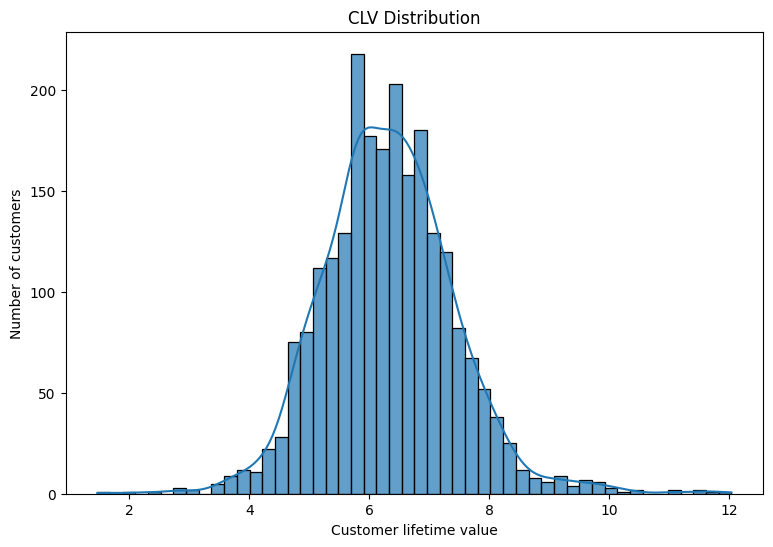

In [104]:
sns.histplot(customer_data['target_clv'],bins=50,alpha=0.7,kde=True)
plt.xlabel('Customer lifetime value')
plt.ylabel('Number of customers')
plt.title('CLV Distribution')
plt.show()

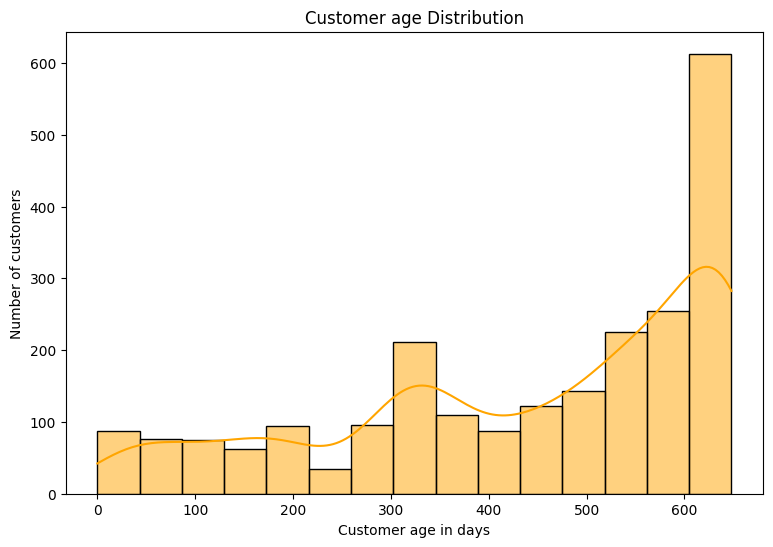

In [105]:
sns.histplot(customer_data['customer_age_days'],color='orange',kde=True)
plt.xlabel('Customer age in days')
plt.ylabel('Number of customers')
plt.title('Customer age Distribution')
plt.show()

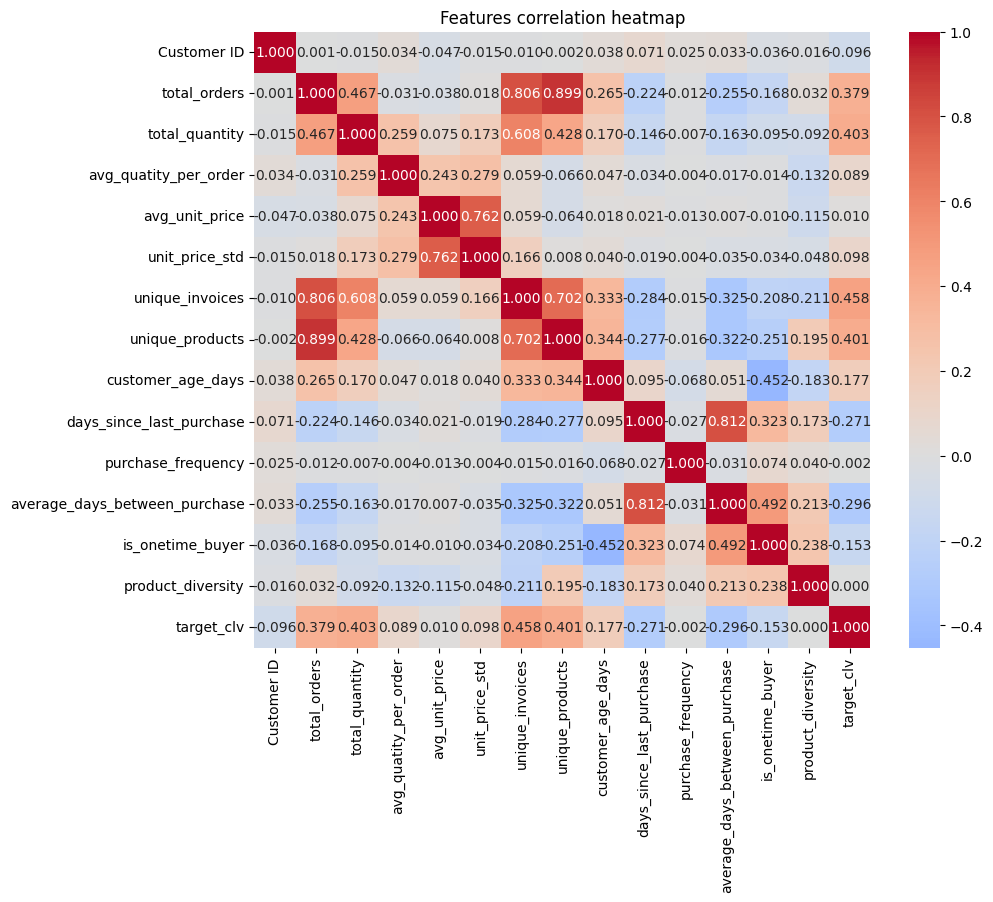

In [106]:
plt.figure(figsize=(10,8))
correlation_matrix = customer_data.corr()
sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm', center=0,
            square=True, fmt='.3f')
plt.title('Features correlation heatmap')
plt.show()

1.  We can se that **unique_invoice, total_quantity, unique_products, days_since_last_purchase and average_days_between_purchase** are correlated with CLV.
2.  There are some multicollinearity to let's inspect them using **VIF**.

In [107]:
from statsmodels.stats.outliers_influence import variance_inflation_factor
from statsmodels.tools.tools import add_constant

features = [
    'total_orders', 'total_quantity', 'avg_quatity_per_order', 'avg_unit_price',
    'unit_price_std', 'unique_invoices', 'unique_products', 'customer_age_days',
    'days_since_last_purchase', 'purchase_frequency',
    'average_days_between_purchase', 'is_onetime_buyer', 'product_diversity'
]
X = customer_data[features].copy()
x_const = add_constant(X)

vif = pd.DataFrame()
vif['features'] = x_const.columns
vif['vif'] = [variance_inflation_factor(x_const.values,i) for i in range(x_const.shape[1])]
vif = vif[vif['features'] != 'const']
vif.sort_values('vif',ascending=False)


,features,vif
1,total_orders,9.358636
7,unique_products,8.822790
6,unique_invoices,4.813205
11,average_days_between_purchase,4.170396
9,days_since_last_purchase,3.044262
5,unit_price_std,2.644097
4,avg_unit_price,2.485399
8,customer_age_days,2.071056
12,is_onetime_buyer,2.015913
13,product_diversity,1.798232




1.   So, let's remove **total_orders and unique_products** because these are possibly inflate our results due to high multicollinearity.
2.   And also **avg_unit_price, product_diversity and purchase_frequency** need to be removed because these have no impact on CLV.



In [108]:
customer_data.drop(columns=['purchase_frequency','product_diversity','avg_unit_price','unique_products','total_orders'],inplace=True)



---

Data preparation

In [109]:
X = customer_data.drop(columns=['Customer ID','target_clv'])
y = customer_data['target_clv']

X_train, X_test, y_train, y_test = train_test_split(X,y,test_size=0.2,random_state=42)

scalar = StandardScaler()
X_train_scaled = scalar.fit_transform(X_train)
X_test_scaled = scalar.transform(X_test)


### Model training

In [110]:
from sklearn.metrics import root_mean_squared_error
# Helper functions
def evaluate_regression(y_true, y_pred):
    return {
        "rmse_log": root_mean_squared_error(y_true, y_pred),
        "mae_log": mean_absolute_error(y_true, y_pred),
        "r2": r2_score(y_true, y_pred)
    }


def inverse_rmse(y_true_log, y_pred_log):
    y_true = np.expm1(y_true_log)
    y_pred = np.expm1(y_pred_log)
    return root_mean_squared_error(y_true, y_pred)

from scipy.stats import spearmanr

def spearman_rank(y_true, y_pred):
    return spearmanr(y_true, y_pred).correlation


### Run 1

In [119]:
with mlflow.start_run(run_name="lr_baseline"):

    mlflow.log_param("model_type", "linear_regression")
    mlflow.log_param("target_horizon_days", 90)
    mlflow.log_param("log_target", True)

    model = LinearRegression()
    model.fit(X_train_scaled, y_train)

    y_pred = model.predict(X_test_scaled)

    metrics = evaluate_regression(y_test, y_pred)
    for k, v in metrics.items():
        mlflow.log_metric(k, v)

    mlflow.log_metric(
        "rmse_currency",
        inverse_rmse(y_test, y_pred)
    )
    mlflow.log_metric("spearman_rank", spearman_rank(y_test, y_pred))

    mlflow.sklearn.log_model(
        model,
        artifact_path="model"
    )


2026/01/15 14:43:36 WARNING mlflow.models.model: `artifact_path` is deprecated. Please use `name` instead.


🏃 View run lr_baseline at: https://dagshub.com/shashi-hue/Mlops-Forward-Customer-Value.mlflow/#/experiments/1/runs/b7e17f7ec5e341b19536185466e21e04
🧪 View experiment at: https://dagshub.com/shashi-hue/Mlops-Forward-Customer-Value.mlflow/#/experiments/1


### Run 2

In [124]:
from sklearn.ensemble import RandomForestRegressor

with mlflow.start_run(run_name="rf_v1"):

    mlflow.log_param("model_type", "random_forest")
    mlflow.log_param("n_estimators", 200)
    mlflow.log_param("max_depth", 10)

    model = RandomForestRegressor(
        n_estimators=200,
        max_depth=10,
        random_state=42,
        n_jobs=-1
    )

    model.fit(X_train_scaled, y_train)
    y_pred = model.predict(X_test_scaled)

    metrics = evaluate_regression(y_test, y_pred)
    for k, v in metrics.items():
        mlflow.log_metric(k, v)

    mlflow.log_metric(
        "rmse_currency",
        inverse_rmse(y_test, y_pred)
    )
    mlflow.log_metric("spearman_rank", spearman_rank(y_test, y_pred))

    mlflow.sklearn.log_model(
        model,
        artifact_path="model"
    )


2026/01/15 14:46:26 WARNING mlflow.models.model: `artifact_path` is deprecated. Please use `name` instead.


🏃 View run rf_v1 at: https://dagshub.com/shashi-hue/Mlops-Forward-Customer-Value.mlflow/#/experiments/1/runs/1abfe2eb2a754de08f245ab2a061173c
🧪 View experiment at: https://dagshub.com/shashi-hue/Mlops-Forward-Customer-Value.mlflow/#/experiments/1


### Run 3

In [128]:
from sklearn.ensemble import RandomForestRegressor

with mlflow.start_run(run_name="rf_depth20_estimators300"):

    mlflow.log_param("model_type", "random_forest")
    mlflow.log_param("n_estimators", 300)
    mlflow.log_param("max_depth", 20)

    model = RandomForestRegressor(
        n_estimators=300,
        max_depth=20,
        min_samples_leaf=5,
        random_state=42,
        n_jobs=-1
    )

    model.fit(X_train_scaled, y_train)
    y_pred = model.predict(X_test_scaled)

    metrics = evaluate_regression(y_test, y_pred)
    for k, v in metrics.items():
        mlflow.log_metric(k, v)

    mlflow.log_metric(
        "rmse_currency",
        inverse_rmse(y_test, y_pred)
    )
    mlflow.log_metric("spearman_rank", spearman_rank(y_test, y_pred))

    mlflow.sklearn.log_model(
        model,
        artifact_path="model"
    )


2026/01/15 14:47:52 WARNING mlflow.models.model: `artifact_path` is deprecated. Please use `name` instead.


🏃 View run rf_depth20_estimators300 at: https://dagshub.com/shashi-hue/Mlops-Forward-Customer-Value.mlflow/#/experiments/1/runs/593b4c4c825a4d4c911b72c6ba5afc57
🧪 View experiment at: https://dagshub.com/shashi-hue/Mlops-Forward-Customer-Value.mlflow/#/experiments/1


### Run 4

In [141]:
with mlflow.start_run(run_name="rf_depth8_estimators500"):

    mlflow.log_param("model_type", "random_forest")
    mlflow.log_param("n_estimators", 500)
    mlflow.log_param("max_depth", 8)

    model = RandomForestRegressor(
        n_estimators=500,
        max_depth=8,
        min_samples_leaf=10,
        random_state=42,
        n_jobs=-1
    )

    model.fit(X_train_scaled, y_train)
    y_pred = model.predict(X_test_scaled)

    metrics = evaluate_regression(y_test, y_pred)
    for k, v in metrics.items():
        mlflow.log_metric(k, v)

    mlflow.log_metric(
        "rmse_currency",
        inverse_rmse(y_test, y_pred)
    )
    mlflow.log_metric("spearman_rank", spearman_rank(y_test, y_pred))

    mlflow.sklearn.log_model(
        model,
        artifact_path="model"
    )


2026/01/15 14:59:53 WARNING mlflow.models.model: `artifact_path` is deprecated. Please use `name` instead.


🏃 View run rf_depth8_estimators500 at: https://dagshub.com/shashi-hue/Mlops-Forward-Customer-Value.mlflow/#/experiments/1/runs/274ed4681e1f4042bea6ecf39aa0d0f6
🧪 View experiment at: https://dagshub.com/shashi-hue/Mlops-Forward-Customer-Value.mlflow/#/experiments/1


### Run 5

In [136]:
from xgboost import XGBRegressor

with mlflow.start_run(run_name="xgb_depth6_lr0.05"):

    mlflow.log_param("model_type", "xgboost")
    mlflow.log_param("max_depth", 6)
    mlflow.log_param("learning_rate", 0.05)
    mlflow.log_param("n_estimators", 500)

    model = XGBRegressor(
        n_estimators=500,
        max_depth=6,
        learning_rate=0.05,
        subsample=0.8,
        colsample_bytree=0.8,
        objective="reg:squarederror",
        random_state=42,
        n_jobs=-1
    )

    model.fit(X_train_scaled, y_train)
    y_pred = model.predict(X_test_scaled)

    metrics = evaluate_regression(y_test, y_pred)
    for k, v in metrics.items():
        mlflow.log_metric(k, v)

    mlflow.log_metric(
        "rmse_currency",
        inverse_rmse(y_test, y_pred)
    )
    mlflow.log_metric("spearman_rank", spearman_rank(y_test, y_pred))

    mlflow.sklearn.log_model(
        model,
        artifact_path="model"
    )


2026/01/15 14:50:11 WARNING mlflow.models.model: `artifact_path` is deprecated. Please use `name` instead.


🏃 View run xgb_depth6_lr0.05 at: https://dagshub.com/shashi-hue/Mlops-Forward-Customer-Value.mlflow/#/experiments/1/runs/414bddd34c8b4df284763bcc77ec2a4d
🧪 View experiment at: https://dagshub.com/shashi-hue/Mlops-Forward-Customer-Value.mlflow/#/experiments/1


A shallow Random Forest with increased ensemble size provided the best trade-off between bias and variance, significantly improving both predictive accuracy and customer ranking stability for forward value prediction.

### Exp 2 (Optuna Tunning)

In [150]:
mlflow.set_experiment("Optuna Tuning RF")

def objective(trial):

    params = {
        "n_estimators": trial.suggest_int("n_estimators", 500, 1000, step=100),
        "max_depth": trial.suggest_int("max_depth", 6, 10),
        "min_samples_leaf": trial.suggest_int("min_samples_leaf", 5, 25, step=5),
        "min_samples_split": trial.suggest_int("min_samples_split", 10, 40, step=5),
        "max_features": trial.suggest_categorical("max_features", ["sqrt", 0.5]),
        "random_state": 42,
        "n_jobs": -1
    }

    with mlflow.start_run(nested=True):

        # Log hyperparameters
        for k, v in params.items():
            mlflow.log_param(k, v)

        model = RandomForestRegressor(**params)
        model.fit(X_train_scaled, y_train)

        y_pred = model.predict(X_test_scaled)

        metrics = evaluate_regression(y_test, y_pred)
        for k, v in metrics.items():
            mlflow.log_metric(k, v)

        mlflow.log_metric(
            "rmse_currency",
            inverse_rmse(y_test, y_pred)
        )
        mlflow.log_metric("spearman_rank", spearman_rank(y_test, y_pred))

        # Optuna should optimize for ranking + accuracy
        # Primary: rmse_log (minimize)
        return metrics["rmse_log"]



In [151]:
import optuna
with mlflow.start_run(run_name="optuna_rf"):

    mlflow.log_param("optimizer", "optuna")

    study = optuna.create_study(direction="minimize")
    study.optimize(objective, n_trials=25)

    mlflow.log_metric("best_rmse_log", study.best_value)


c:\Users\shash\Mlops-Forward-Customer-Value\venv\Lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm
[I 2026-01-15 16:21:57,899] A new study created in memory with name: no-name-e1616bf9-8d47-46fc-b5f2-30732b52344c


🏃 View run unique-mule-3 at: https://dagshub.com/shashi-hue/Mlops-Forward-Customer-Value.mlflow/#/experiments/3/runs/f0840efe294049bd89f73321df2a6db3
🧪 View experiment at: https://dagshub.com/shashi-hue/Mlops-Forward-Customer-Value.mlflow/#/experiments/3


[I 2026-01-15 16:22:05,376] Trial 0 finished with value: 0.7700675745184828 and parameters: {'n_estimators': 600, 'max_depth': 10, 'min_samples_leaf': 20, 'min_samples_split': 10, 'max_features': 0.5}. Best is trial 0 with value: 0.7700675745184828.


🏃 View run abrasive-whale-465 at: https://dagshub.com/shashi-hue/Mlops-Forward-Customer-Value.mlflow/#/experiments/3/runs/2d47c6dafdef4dcbad5252e03ca5e564
🧪 View experiment at: https://dagshub.com/shashi-hue/Mlops-Forward-Customer-Value.mlflow/#/experiments/3


[I 2026-01-15 16:22:18,512] Trial 1 finished with value: 0.7703641812631464 and parameters: {'n_estimators': 900, 'max_depth': 7, 'min_samples_leaf': 10, 'min_samples_split': 15, 'max_features': 0.5}. Best is trial 0 with value: 0.7700675745184828.


🏃 View run unleashed-sloth-695 at: https://dagshub.com/shashi-hue/Mlops-Forward-Customer-Value.mlflow/#/experiments/3/runs/11c7adae85e54ebda3481343e584a42b
🧪 View experiment at: https://dagshub.com/shashi-hue/Mlops-Forward-Customer-Value.mlflow/#/experiments/3


[I 2026-01-15 16:22:33,525] Trial 2 finished with value: 0.7989719692866579 and parameters: {'n_estimators': 800, 'max_depth': 7, 'min_samples_leaf': 20, 'min_samples_split': 35, 'max_features': 'sqrt'}. Best is trial 0 with value: 0.7700675745184828.


🏃 View run learned-finch-442 at: https://dagshub.com/shashi-hue/Mlops-Forward-Customer-Value.mlflow/#/experiments/3/runs/e5983d322b9147f6a9769b1b01b17879
🧪 View experiment at: https://dagshub.com/shashi-hue/Mlops-Forward-Customer-Value.mlflow/#/experiments/3


[I 2026-01-15 16:22:48,458] Trial 3 finished with value: 0.7884064326053528 and parameters: {'n_estimators': 500, 'max_depth': 10, 'min_samples_leaf': 5, 'min_samples_split': 35, 'max_features': 'sqrt'}. Best is trial 0 with value: 0.7700675745184828.


🏃 View run suave-lamb-447 at: https://dagshub.com/shashi-hue/Mlops-Forward-Customer-Value.mlflow/#/experiments/3/runs/e9b9a1ab16ec49d282497d5206e904be
🧪 View experiment at: https://dagshub.com/shashi-hue/Mlops-Forward-Customer-Value.mlflow/#/experiments/3


[I 2026-01-15 16:23:03,510] Trial 4 finished with value: 0.7997709086468111 and parameters: {'n_estimators': 700, 'max_depth': 6, 'min_samples_leaf': 15, 'min_samples_split': 40, 'max_features': 'sqrt'}. Best is trial 0 with value: 0.7700675745184828.


🏃 View run unruly-turtle-498 at: https://dagshub.com/shashi-hue/Mlops-Forward-Customer-Value.mlflow/#/experiments/3/runs/91dc4b8ea958436fab8ac26d6cd48dce
🧪 View experiment at: https://dagshub.com/shashi-hue/Mlops-Forward-Customer-Value.mlflow/#/experiments/3


[I 2026-01-15 16:23:18,594] Trial 5 finished with value: 0.7951638523046852 and parameters: {'n_estimators': 900, 'max_depth': 7, 'min_samples_leaf': 10, 'min_samples_split': 40, 'max_features': 'sqrt'}. Best is trial 0 with value: 0.7700675745184828.


🏃 View run upbeat-auk-254 at: https://dagshub.com/shashi-hue/Mlops-Forward-Customer-Value.mlflow/#/experiments/3/runs/68182b25bf904bd296c6921a10f751ef
🧪 View experiment at: https://dagshub.com/shashi-hue/Mlops-Forward-Customer-Value.mlflow/#/experiments/3


[I 2026-01-15 16:23:33,492] Trial 6 finished with value: 0.7729650334929753 and parameters: {'n_estimators': 700, 'max_depth': 7, 'min_samples_leaf': 5, 'min_samples_split': 30, 'max_features': 0.5}. Best is trial 0 with value: 0.7700675745184828.


🏃 View run smiling-snipe-797 at: https://dagshub.com/shashi-hue/Mlops-Forward-Customer-Value.mlflow/#/experiments/3/runs/fb273e5109624800abab82de42a0dda8
🧪 View experiment at: https://dagshub.com/shashi-hue/Mlops-Forward-Customer-Value.mlflow/#/experiments/3


[I 2026-01-15 16:23:48,504] Trial 7 finished with value: 0.7690375783361063 and parameters: {'n_estimators': 900, 'max_depth': 8, 'min_samples_leaf': 15, 'min_samples_split': 30, 'max_features': 0.5}. Best is trial 7 with value: 0.7690375783361063.


🏃 View run sedate-moose-233 at: https://dagshub.com/shashi-hue/Mlops-Forward-Customer-Value.mlflow/#/experiments/3/runs/d75adf4b7b074a1ba8c2a4e4537f26e1
🧪 View experiment at: https://dagshub.com/shashi-hue/Mlops-Forward-Customer-Value.mlflow/#/experiments/3


[I 2026-01-15 16:24:03,505] Trial 8 finished with value: 0.7766879131407542 and parameters: {'n_estimators': 500, 'max_depth': 6, 'min_samples_leaf': 5, 'min_samples_split': 20, 'max_features': 0.5}. Best is trial 7 with value: 0.7690375783361063.


🏃 View run luminous-horse-662 at: https://dagshub.com/shashi-hue/Mlops-Forward-Customer-Value.mlflow/#/experiments/3/runs/4cf7af6e8a05490882ebcc3703ad4986
🧪 View experiment at: https://dagshub.com/shashi-hue/Mlops-Forward-Customer-Value.mlflow/#/experiments/3


[I 2026-01-15 16:24:18,458] Trial 9 finished with value: 0.7991530970556818 and parameters: {'n_estimators': 900, 'max_depth': 10, 'min_samples_leaf': 25, 'min_samples_split': 25, 'max_features': 'sqrt'}. Best is trial 7 with value: 0.7690375783361063.


🏃 View run glamorous-turtle-441 at: https://dagshub.com/shashi-hue/Mlops-Forward-Customer-Value.mlflow/#/experiments/3/runs/71f27c70e9a142e79591ecbd91e59302
🧪 View experiment at: https://dagshub.com/shashi-hue/Mlops-Forward-Customer-Value.mlflow/#/experiments/3


[I 2026-01-15 16:24:33,505] Trial 10 finished with value: 0.7690086115429144 and parameters: {'n_estimators': 1000, 'max_depth': 9, 'min_samples_leaf': 15, 'min_samples_split': 25, 'max_features': 0.5}. Best is trial 10 with value: 0.7690086115429144.


🏃 View run orderly-panda-55 at: https://dagshub.com/shashi-hue/Mlops-Forward-Customer-Value.mlflow/#/experiments/3/runs/0ad67334f5cb462cbd9bdc5f414a2aa9
🧪 View experiment at: https://dagshub.com/shashi-hue/Mlops-Forward-Customer-Value.mlflow/#/experiments/3


[I 2026-01-15 16:24:48,513] Trial 11 finished with value: 0.7690086115429144 and parameters: {'n_estimators': 1000, 'max_depth': 9, 'min_samples_leaf': 15, 'min_samples_split': 25, 'max_features': 0.5}. Best is trial 10 with value: 0.7690086115429144.


🏃 View run nimble-lark-382 at: https://dagshub.com/shashi-hue/Mlops-Forward-Customer-Value.mlflow/#/experiments/3/runs/782a22f63ea74a838362c9f18f7f8c6d
🧪 View experiment at: https://dagshub.com/shashi-hue/Mlops-Forward-Customer-Value.mlflow/#/experiments/3


[I 2026-01-15 16:25:03,558] Trial 12 finished with value: 0.7690086115429144 and parameters: {'n_estimators': 1000, 'max_depth': 9, 'min_samples_leaf': 15, 'min_samples_split': 20, 'max_features': 0.5}. Best is trial 10 with value: 0.7690086115429144.


🏃 View run industrious-elk-379 at: https://dagshub.com/shashi-hue/Mlops-Forward-Customer-Value.mlflow/#/experiments/3/runs/510b3468d92f4ec68dc887f0e2ac3039
🧪 View experiment at: https://dagshub.com/shashi-hue/Mlops-Forward-Customer-Value.mlflow/#/experiments/3


[I 2026-01-15 16:25:18,558] Trial 13 finished with value: 0.7703999668487046 and parameters: {'n_estimators': 1000, 'max_depth': 9, 'min_samples_leaf': 20, 'min_samples_split': 25, 'max_features': 0.5}. Best is trial 10 with value: 0.7690086115429144.


🏃 View run clumsy-hound-29 at: https://dagshub.com/shashi-hue/Mlops-Forward-Customer-Value.mlflow/#/experiments/3/runs/9167f23d8da948ffbe8083d217021999
🧪 View experiment at: https://dagshub.com/shashi-hue/Mlops-Forward-Customer-Value.mlflow/#/experiments/3


[I 2026-01-15 16:25:33,464] Trial 14 finished with value: 0.768562612912704 and parameters: {'n_estimators': 1000, 'max_depth': 9, 'min_samples_leaf': 10, 'min_samples_split': 20, 'max_features': 0.5}. Best is trial 14 with value: 0.768562612912704.


🏃 View run rebellious-dog-914 at: https://dagshub.com/shashi-hue/Mlops-Forward-Customer-Value.mlflow/#/experiments/3/runs/8599869794e74911a28d50c5d2641da6
🧪 View experiment at: https://dagshub.com/shashi-hue/Mlops-Forward-Customer-Value.mlflow/#/experiments/3


[I 2026-01-15 16:25:48,486] Trial 15 finished with value: 0.7696275188512266 and parameters: {'n_estimators': 800, 'max_depth': 8, 'min_samples_leaf': 10, 'min_samples_split': 15, 'max_features': 0.5}. Best is trial 14 with value: 0.768562612912704.


🏃 View run bright-mole-958 at: https://dagshub.com/shashi-hue/Mlops-Forward-Customer-Value.mlflow/#/experiments/3/runs/3966746cfd1047fab8ee51e05b507149
🧪 View experiment at: https://dagshub.com/shashi-hue/Mlops-Forward-Customer-Value.mlflow/#/experiments/3


[I 2026-01-15 16:26:03,499] Trial 16 finished with value: 0.768562612912704 and parameters: {'n_estimators': 1000, 'max_depth': 9, 'min_samples_leaf': 10, 'min_samples_split': 20, 'max_features': 0.5}. Best is trial 14 with value: 0.768562612912704.


🏃 View run smiling-trout-601 at: https://dagshub.com/shashi-hue/Mlops-Forward-Customer-Value.mlflow/#/experiments/3/runs/8a1345acf9e3447db1d5127791c6d13b
🧪 View experiment at: https://dagshub.com/shashi-hue/Mlops-Forward-Customer-Value.mlflow/#/experiments/3


[I 2026-01-15 16:26:18,586] Trial 17 finished with value: 0.7696275188512267 and parameters: {'n_estimators': 800, 'max_depth': 8, 'min_samples_leaf': 10, 'min_samples_split': 15, 'max_features': 0.5}. Best is trial 14 with value: 0.768562612912704.


🏃 View run peaceful-cat-446 at: https://dagshub.com/shashi-hue/Mlops-Forward-Customer-Value.mlflow/#/experiments/3/runs/159b150387ff4bfda7ddf24af0d98467
🧪 View experiment at: https://dagshub.com/shashi-hue/Mlops-Forward-Customer-Value.mlflow/#/experiments/3


[I 2026-01-15 16:26:33,635] Trial 18 finished with value: 0.768562612912704 and parameters: {'n_estimators': 1000, 'max_depth': 9, 'min_samples_leaf': 10, 'min_samples_split': 20, 'max_features': 0.5}. Best is trial 14 with value: 0.768562612912704.


🏃 View run painted-kite-575 at: https://dagshub.com/shashi-hue/Mlops-Forward-Customer-Value.mlflow/#/experiments/3/runs/32c6fbc3f116459da3711da2f08c2118
🧪 View experiment at: https://dagshub.com/shashi-hue/Mlops-Forward-Customer-Value.mlflow/#/experiments/3


[I 2026-01-15 16:26:48,517] Trial 19 finished with value: 0.7736432693863982 and parameters: {'n_estimators': 900, 'max_depth': 10, 'min_samples_leaf': 5, 'min_samples_split': 10, 'max_features': 0.5}. Best is trial 14 with value: 0.768562612912704.


🏃 View run fortunate-mare-801 at: https://dagshub.com/shashi-hue/Mlops-Forward-Customer-Value.mlflow/#/experiments/3/runs/d448f0e761eb4db6a64873631a79dc3d
🧪 View experiment at: https://dagshub.com/shashi-hue/Mlops-Forward-Customer-Value.mlflow/#/experiments/3


[I 2026-01-15 16:27:03,508] Trial 20 finished with value: 0.768682983266874 and parameters: {'n_estimators': 600, 'max_depth': 9, 'min_samples_leaf': 10, 'min_samples_split': 20, 'max_features': 0.5}. Best is trial 14 with value: 0.768562612912704.


🏃 View run redolent-vole-19 at: https://dagshub.com/shashi-hue/Mlops-Forward-Customer-Value.mlflow/#/experiments/3/runs/c24b685d565c4ff7a86a157b4203b7ac
🧪 View experiment at: https://dagshub.com/shashi-hue/Mlops-Forward-Customer-Value.mlflow/#/experiments/3


[I 2026-01-15 16:27:18,594] Trial 21 finished with value: 0.768562612912704 and parameters: {'n_estimators': 1000, 'max_depth': 9, 'min_samples_leaf': 10, 'min_samples_split': 20, 'max_features': 0.5}. Best is trial 14 with value: 0.768562612912704.


🏃 View run stately-bat-935 at: https://dagshub.com/shashi-hue/Mlops-Forward-Customer-Value.mlflow/#/experiments/3/runs/001e78052e934d3186153645587c844e
🧪 View experiment at: https://dagshub.com/shashi-hue/Mlops-Forward-Customer-Value.mlflow/#/experiments/3


[I 2026-01-15 16:27:33,509] Trial 22 finished with value: 0.7696045855580956 and parameters: {'n_estimators': 1000, 'max_depth': 8, 'min_samples_leaf': 10, 'min_samples_split': 15, 'max_features': 0.5}. Best is trial 14 with value: 0.768562612912704.


🏃 View run popular-asp-962 at: https://dagshub.com/shashi-hue/Mlops-Forward-Customer-Value.mlflow/#/experiments/3/runs/893e5803ee9449e5b8613e51ab135403
🧪 View experiment at: https://dagshub.com/shashi-hue/Mlops-Forward-Customer-Value.mlflow/#/experiments/3


[I 2026-01-15 16:27:48,511] Trial 23 finished with value: 0.770889832196389 and parameters: {'n_estimators': 900, 'max_depth': 9, 'min_samples_leaf': 5, 'min_samples_split': 20, 'max_features': 0.5}. Best is trial 14 with value: 0.768562612912704.


🏃 View run bustling-bird-71 at: https://dagshub.com/shashi-hue/Mlops-Forward-Customer-Value.mlflow/#/experiments/3/runs/78410ca8ae5c41808b38b6b5f9f96a58
🧪 View experiment at: https://dagshub.com/shashi-hue/Mlops-Forward-Customer-Value.mlflow/#/experiments/3


[I 2026-01-15 16:28:03,502] Trial 24 finished with value: 0.7681670396687712 and parameters: {'n_estimators': 1000, 'max_depth': 10, 'min_samples_leaf': 10, 'min_samples_split': 30, 'max_features': 0.5}. Best is trial 24 with value: 0.7681670396687712.


🏃 View run optuna_rf at: https://dagshub.com/shashi-hue/Mlops-Forward-Customer-Value.mlflow/#/experiments/3/runs/1c0e976acd5a45d689e44f119603589e
🧪 View experiment at: https://dagshub.com/shashi-hue/Mlops-Forward-Customer-Value.mlflow/#/experiments/3


In [152]:
best_params = study.best_params

with mlflow.start_run(run_name="rf_optuna_best"):

    for k, v in best_params.items():
        mlflow.log_param(k, v)

    model = RandomForestRegressor(
        **best_params,
        random_state=42,
        n_jobs=-1
    )

    model.fit(X_train_scaled, y_train)
    y_pred = model.predict(X_test_scaled)

    metrics = evaluate_regression(y_test, y_pred)
    for k, v in metrics.items():
        mlflow.log_metric(k, v)

    mlflow.log_metric(
        "rmse_currency",
        inverse_rmse(y_test, y_pred)
    )
    mlflow.log_metric("spearman_rank", spearman_rank(y_test, y_pred))

    mlflow.sklearn.log_model(
        model,
        artifact_path="model"
    )


2026/01/15 16:28:17 WARNING mlflow.models.model: `artifact_path` is deprecated. Please use `name` instead.


🏃 View run rf_optuna_best at: https://dagshub.com/shashi-hue/Mlops-Forward-Customer-Value.mlflow/#/experiments/3/runs/6c2497a3fd0e42a3af8c5c5e52beeeec
🧪 View experiment at: https://dagshub.com/shashi-hue/Mlops-Forward-Customer-Value.mlflow/#/experiments/3


In [153]:
y_pred = model.predict(X_test_scaled)
y_pred_train = model.predict(X_train_scaled)
r2 = r2_score(y_test,y_pred)
mse = mean_squared_error(y_test,y_pred)
rmse = np.sqrt(mean_squared_error(y_test,y_pred))
mae = mean_absolute_error(y_test,y_pred)
train_rmse = np.sqrt(mean_squared_error(y_train,y_pred_train))

print(f"- R²: {r2:.3f} (explains {r2*100:.1f}% of variance)")
print(f"- MSE: {mse:.3f}")
print(f"- RMSE: {rmse:.2f}")
print(f"- MAE: {mae:.2f}")
print(f"- Train vs Test RMSE: {train_rmse:.2f} vs {rmse:.2f}")


- R²: 0.445 (explains 44.5% of variance)
- MSE: 0.590
- RMSE: 0.77
- MAE: 0.59
- Train vs Test RMSE: 0.74 vs 0.77


In [154]:
#actual vs predicted clv mean

print(f"actual mean: {y_test.mean()} VS Predicted mean: {y_pred.mean()}")

actual mean: 6.34949493773221 VS Predicted mean: 6.292748671842089


This mean the model if highly accurate on average but the Individual predictions are off (which we saw with R² = 0.236) or model struggles on extreme(low/high) CLV values.

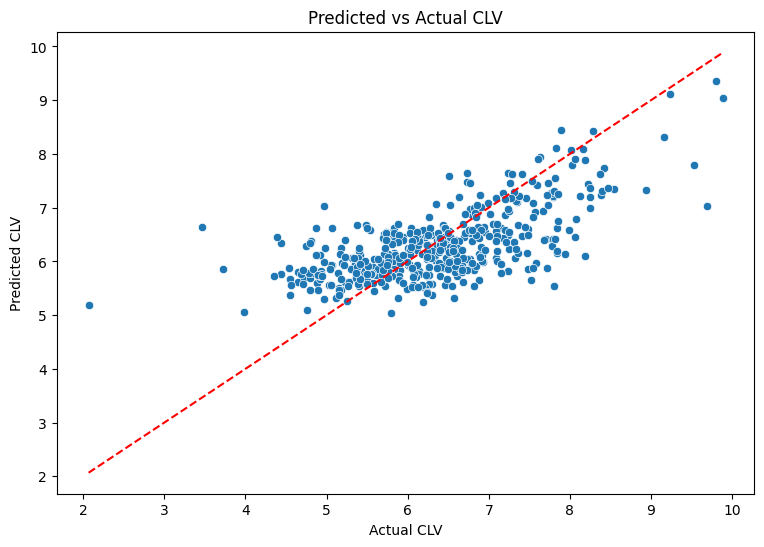

In [155]:
sns.scatterplot(x=y_test, y=y_pred)
plt.xlabel("Actual CLV")
plt.ylabel("Predicted CLV")
plt.title("Predicted vs Actual CLV")
plt.plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], 'r--')
plt.show()


### Visualization assumptions

Residuals plot

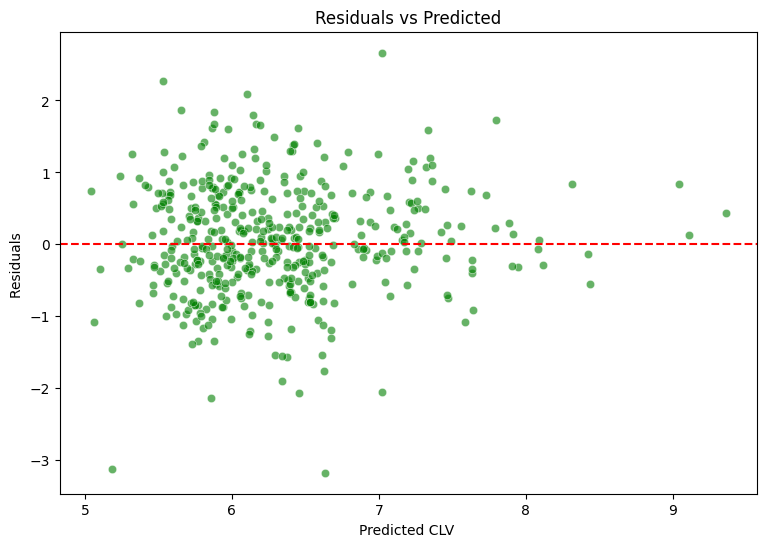

In [156]:
residuals = y_test - y_pred
sns.scatterplot(x=y_pred,y=residuals,alpha=0.6,color='green')
plt.axhline(y=0, color='red', linestyle='--')
plt.xlabel('Predicted CLV ')
plt.ylabel('Residuals ')
plt.title('Residuals vs Predicted')
plt.show()


Residuals are randomly scattered around 0, so no problem.



---

Residuals histogram

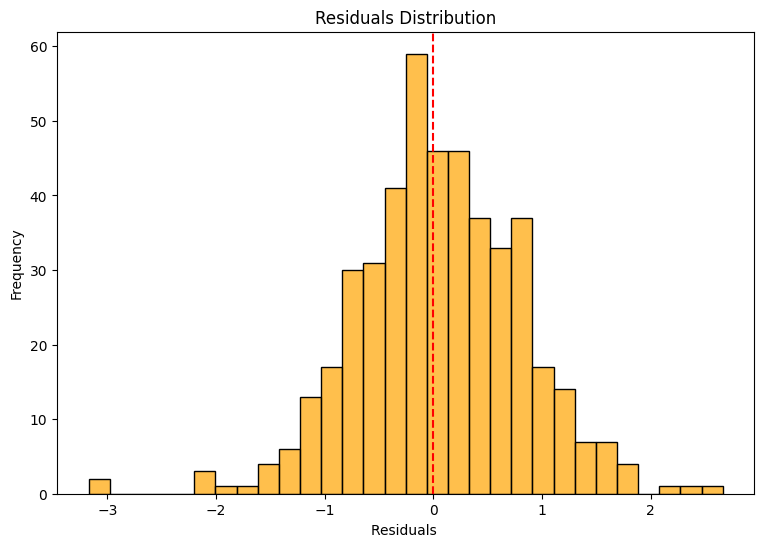

In [157]:

sns.histplot(residuals, bins=30, alpha=0.7, color='orange', edgecolor='black')
plt.axvline(0, color='red', linestyle='--')
plt.xlabel('Residuals ')
plt.ylabel('Frequency')
plt.title('Residuals Distribution')
plt.show()


Residuals are normally distributed